In [1]:
# This cell is tagged for removal

import os
import math
import pickle
from glob import glob

import numpy as np
import pandas as pd
import sympy
sympy.init_printing(use_unicode=False, wrap_line=False)
from IPython import display as idisplay

from sklearn.metrics import r2_score

import aliases # important this goes first to configure PATH

from everest.window import Canvas, plot, raster, DataChannel as Channel, get_cmap
from everest.window.colourmaps import *
from everest.window import image, imop

from referencing import search
from myst_nb import glue
from analysis import isovisc, arrhenius, utilities, common, analysis, visualisation
%matplotlib inline

osjoin = os.path.join

import warnings

warnings.filterwarnings("ignore",category=UserWarning)

### Isoviscous rheology in cylindrical geometry

#### Defining a coordinate system

In any convection model, gravity defines the natural down direction and gives us our first most important scale: the depth $z$ from the surface, or its complement, the height from the model base $h=1-z$.

If the domain is allowed to curve around a certain locus, a cylindrical or annular geometry is obtained which is more appropriate for planetary mantles. While we retain $h$ and $z$ as terms relevant to any action within the domain, we must also introduce a concept of radial height $r$, understood here to represent the distance from the planetary centre of gravity. The cylindrical domain, for us representing the mantle, is thus bounded by the inner radius $r_{i}$ and the outer radius $r_{o}$, defining an area of $\pi(r_o^2 - r_i^2)$.

Our choice of radii implies a degree of curvature $f$:

$$ f \equiv \frac{r_o}{r_i} $$

Where $f=1$ is equivalent to an infinitely wide Cartesian box, $f\to0$ represents a full disk, and the values $\sim 0.5$ and $\sim 0.9$ would be appropriate for the whole mantle and upper mantle respectively. The ratio of radii $f$ is identical to the ratio of circumferences, so that $f=0.5$ represents a system where the arc length of the base is half that of the surface. (Note that this would imply infinite planetary radii at $f=1$ - hence the planar-like endmember $f=1$ is not strictly reachable under an assumption of curvature, though arbitrarily high values can be set to reproduce that behaviour {cite}`Jarvis1993-cb`.)

If we further stipulate:

$$
\Delta r = r_{o} - r_{i} = 1 \\
r_{o} \to 1 \quad as \quad f \to 0
$$

Then:

$$
r_i = \frac{f}{1 - f}, \quad r_o = \frac{1}{1 - f} \\
r(h) = r_i + h
$$

Which suggests non-dimensionalising the planetary radial height $r$ as $r^{*}$ (*r-star*) such that ${r^{*}}_o = 1$:

$$
{r^{*}}_i = f, \quad {r^{*}}_o = 1 \\
\Delta r^{*} = 1 - f \\
r^{*}(h) = \frac{h + r_i}{r_0} = \frac{\Delta r^{*}}{r} = h(1-f) + f
$$

This leaves us with four different terms to describe radial position: $h$, the dimensionless height from the mantle base; $z$, its complement; $r$, the radial scale such that $r_o - r_i = 1$; and $r^{*}$, the radial scale such that $r_0 = 1$. Each of these scales will prove natural in some contexts and less so in others, and all find use in our analysis.

To complete our coordinate system, we require an angular coordinate as well: the angle $\theta$ in radians anticlockwise from an arbitrary origin. Often we will only want to reproduce a small wedge of the annulus, as time-dependence and numerical workload scale exponentially with aspect ratio; we can define our wedge selection $\Theta$ in radians:

$$ \theta: 0 \to \Theta, \quad \Theta \leq 2\pi $$

If the simulation is to represent periodic flow around the annulus, values of $\Theta$ must satsify $\pi / l$, where $l$ is a positive integer representing the number of convection cell pairs it would take to populate the full annulus at equivalent curvature (i.e. the number of upwellings or downwellings).

The selection of $\Theta$ also selects an aspect ratio for the domain, but only once we choose a depth at which to measure it. It is most convenient to use the arc length through the mid-depth, which then relates to $\Theta$ and $f$ via a new term: the radial distance from the planetary centre of gravity to the mantle mid-depth, $r_m$:

$$
r_m \equiv \frac{r_{i} + r_{o}}{2} = \frac{1 + f}{2 \left( 1 - f \right)} \\
A = r_m \Theta
$$

If radius has been non-dimensionalised as above, this is equivalent to stating that the aspect ratio is equal to the area of the domain - regardless of $f$ - just as it is in the Cartesian case.

Such a scheme leaves us with two competing claims for a 'natural' denominator of the angular coordinate - $\Theta$ and $r_m$. While authors have sometimes preferred to keep $\Theta$ and $r_m$ constant and allow $A$ to vary {cite}`Jarvis1994-np`, we have for the most part chosen to fix $A$ and $r_m$ with $\Theta$ as the free parameter, as in {cite}`Jarvis1993-cb`: this simplifies comparisons with plane-layer simulations at the cost of producing planforms which would be unstable if scaled to the full annulus.

Some system forcings, like internal heat, scale with area. The proportion of the annulus lying below a particular height $h$ - which we shall call $D$ for 'disk' - is a function of the inner and mid-radii:

$$
D(h) = \frac{r^2 - {r_i}^2}{2 r_m}, \quad r = h + r_i
$$

Having declared that the total area shall always equal the aspect ratio $A$, the true area under any depth $h$ is simply $D \cdot A$.

From $r_m$ we are also able to derive $s$, a statement of the angular length in 'real' terms (i.e. in the same metric as $r$). It is convenient to non-dimensionalise $s$ as $s^{*} = s / A$, such that the dimensionless length through the mid-depth ${s^{*}}_m = 1$. We can then write $s^{*}$ very simply as a function of $r^{*}$, and the inner and outer lengths accordingly:

$$
s^{*} = 2 \frac{r^{*}}{1+f} \\
{s^{*}}_i = 2 \frac{f}{1+f}, \quad {s^{*}}_o = 2 \frac{1}{1+f}
$$

The length $s$ is, among other things, the factor by which an average measurement of some variable taken across a layer can be converted into a total value for that layer. It is vital to account for varying $s$ whenever comparing between different layers in a given system, or between equivalent layers in systems of differing $f$.

In [2]:
_h, _A, _H = sympy.symbols(('h', 'A', 'H'), positive = True, real = True)
_f = sympy.Symbol('f', positive = True)
_ro = 1 / (1 - _f)
_ri = _ro * _f
_r = _h + _ri
_rstar = (_h + _ri) / _ro
_rm = (_ri + _ro) / 2
_Theta = _A / _rm
_D = (_r**2 - _ri**2) / (2 * _rm)
_sstar = 2 * _rstar / (1 + _f)
_sstari = 2 * _f / (1 + _f)
_sstaro = 2 / (1 + _f)

In [3]:
def r_outer(f):
    return 1 / (1 - f)
def r_inner(f):
    return r_outer(f) * f
def radius(h, f):
    return h + r_inner(f)
def r_mid(f):
    return (r_inner(f) + r_outer(f)) / 2

def r_star(h, f):
    rinner, router = r_inner(f), r_outer(f)
    rstar = (h + rinner) / router # equiv to (h * (1 - f) + f)
    return rstar

def s_star(h, f):
    return 2 * r_star(h, f) / (1 + f)

def sub_area(h, f):
    if f == 1:
        return h
    return (radius(h, f)**2 - r_inner(f)**2) / (2 * r_mid(f))

#     for h in [0, 0.3, 0.5, 0.8, 0.99]:
#         print(f"    h = {h}")
#         print(f"        {sub_area(h, f)}")

#### Basal heating

##### Conductive solution

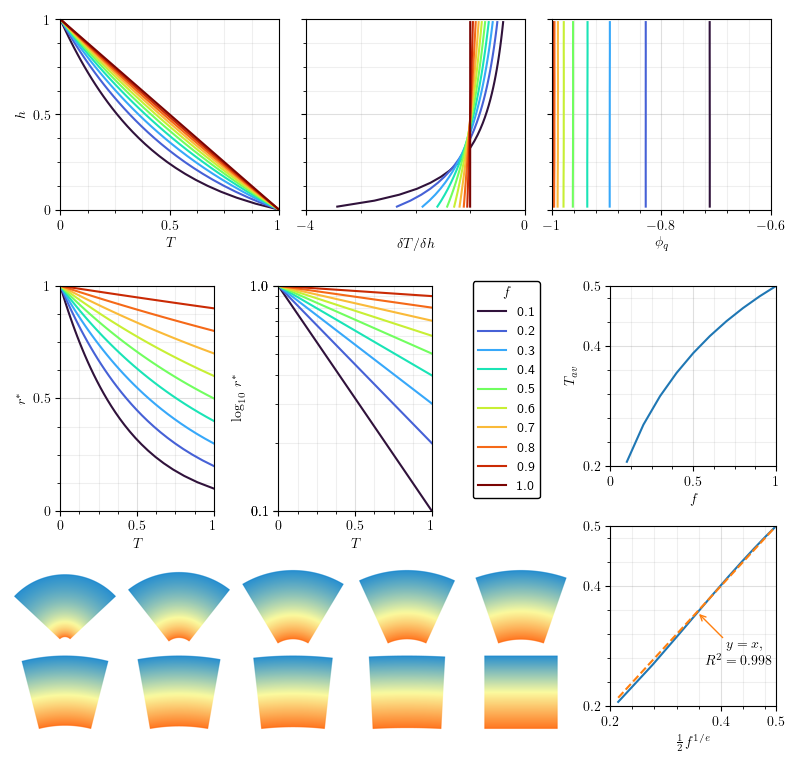

In [4]:
# fs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# geotherms = []
# condavts = []
# for f in fs:
#     system = Isovisc(alpha = 1., f = f, res = 32)
#     system.initialise()
#     temp = system.locals.temperatureField
#     diff = system.locals.diffusivityFn
#     cond = pfn.conduction.default(temp, 0, diff)
#     condavt = pfn.integral.volume(cond).data
#     left = pfn.surface.left(cond)
#     fig = QuickFig(cond, background = 'white', edgecolour = 'white')
#     geotherms.append(left.data)
#     condavts.append(condavt)
#     fig.save('cond_f' + str(f).replace('.', '-'))
# out = {
#     'fs': fs,
#     'geotherms': geotherms,
#     'avts': condavts,
#     }
# with open('cond.pkl', mode = 'wb') as file:
#     file.write(pickle.dumps(out))

impaths = sorted(os.path.relpath(path) for path in glob(osjoin(aliases.storagedir, 'cond_f*.png')))
ims = tuple(image.fromfile(path) for path in impaths)
thumbs = imop.vstack(
    imop.hstack(*ims[:5]),
    imop.hstack(*ims[5:]),
    )

with open(osjoin(aliases.storagedir, 'condf.pkl'), mode = 'rb') as file:
    conddata = pickle.loads(file.read())
condgeotherms, condavts, condfs = (conddata[key] for key in ('geotherms', 'avts', 'fs'))

# Canvas 0

canvas0 = Canvas(size = (8, 8/3), shape = (1, 3))
ax1 = canvas0.make_ax((0, 0))
ax2 = canvas0.make_ax((0, 1))
ax3 = canvas0.make_ax((0, 2))
for f, T in zip(condfs, condgeotherms):
    f = min(0.999, f)
    h = np.linspace(0, 1, len(T))
    dT, hdT = analysis.derivative(T, h, n = 1)
    sstar = s_star(hdT, f)
    phi = dT * sstar
    ax1.line(
        Channel(T, label = 'T'),
        Channel(h, label = 'h', lims = (0, 1)),
        c = cmap(f, condfs, style = 'turbo'),
        )
    ax2.line(
        Channel(dT, label = '\delta T / \delta h', lims = (-4, 0), capped = (True, True)),
        Channel(hdT, label = 'h', lims = (0, 1)),
        c = cmap(f, condfs, style = 'turbo'),
        )
    ax3.line(
        Channel(phi, label = '\phi_q', lims = (-1, -0.6)),
        Channel(hdT, label = 'h', lims = (0, 1)),
        c = cmap(f, condfs, style = 'turbo'),
        )
for ax in (ax2, ax3):
    ax.props.edges.y.ticks.major.labels = []
    ax.props.edges.y.label.visible = False

# Canvas 1

canvas1 = Canvas(shape = (1, 2), size = (5.5, 3))

ax1 = canvas1.make_ax((0, 0))
ax2 = canvas1.make_ax((0, 1))

fslopes = []

for f, T in zip(condfs, condgeotherms):

    f = min(0.999, f)

    h = np.linspace(0, 1, len(T))
    rstar = r_star(h, f)

    ax1.line(
        Tchan := Channel(T, label = 'T'),
        Channel(rstar, label = 'r^{*}'),
        c = cmap(f, condfs, style = 'turbo'),
        )

    ax2.line(
        Tchan,
        Channel(rstar, label = r"r^{*}", capped = (True, True), log = True),
        c = cmap(f, condfs, style = 'turbo'),
        )

    fslopes.append(np.mean(np.gradient(T, np.log(rstar), edge_order = 2)))

fslopes = np.array(fslopes)

# ax2.props.edges.y.swap()

ax2.props.legend.set_handles_labels(
    (row[0] for row in ax1.collections),
    (str(f) for f in condfs),
    )
ax2.props.legend.title.text = 'f'
ax2.props.legend.title.visible = True
ax2.props.legend.mplprops['bbox_to_anchor'] = (1.75, 1.05)
# ax1.props.legend.mplprops['ncol'] = 2
ax2.props.legend.frame.colour = 'black'
ax2.props.legend.frame.visible = True

# Canvas 2

canvas2 = Canvas(size = (2.5, 5), shape = (2, 1))

ax1 = canvas2.make_ax(place = (0, 0))
ax1.line(
    Channel(condfs, label = 'f', lims = (0, 1.), capped = (True, True)),
    Tchan := Channel(condavts, label = 'T_{av}', lims = (0.2, 0.5), capped = (True, True)),
    )

def func(f):
    return 0.5 * f ** (1. / math.e)
predf = np.array(list(map(func, condfs)))
ax2 = canvas2.make_ax(place = (1, 0))
ax2.line(
    predfchan := Channel(predf, label = r'\frac{1}{2}f^{1/e}', lims = (0.2, 0.5), capped = (True, True)),
    Tchan,
    )
linscore = r2_score(predf, condavts)
ax2.line(
    predfchan,
    Channel(predfchan.data, lims = Tchan.lims, capped = Tchan.capped),
    linestyle = '--'
    )
trendlabel = r'y=x, \\ R^2 =' + str(round(linscore, 3))
ax2.annotate(
    predf[3],
    predf[3],
    label = trendlabel,
    points = (30, -30),
    arrowProps = dict(arrowstyle = "->", color = '#ff7f0e'),
    )

# Assembly

# fig = imop.hstack(imop.vstack(canvas1, thumbs), canvas2)
fig = imop.paste(
    imop.vstack(canvas0, imop.hstack(canvas1, canvas2, pad = (255, 255, 255))),
    imop.resize(thumbs, size = 0.178),
    coord = (0.01, 0.96),
    corner = 'bl',
    )

# canvas = Canvas(size = (3, 5))
# ax = canvas.make_ax()
# for condgeotherm in condgeotherms:
#     ax.line(
#         Channel(np.diff(condgeotherms[0]) / np.diff(h), label = r'\frac{dT}{dh}'),
#         Channel(h[:-1], label = 'h', lims = (0, 1), capped = (True, True)),
#         )
# canvas

# Display

glue("isocondf", fig, display = False)
glue("isocondfr2", linscore, display = False)

fig

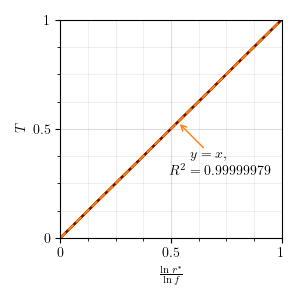

In [5]:
canvas = Canvas(size = (3, 3))
ax = canvas.make_ax()
allT, allr = [], []
for f, T in zip(condfs, condgeotherms):
    f = min(0.999, f)
    h = np.linspace(0, 1, len(T))
    rstar = r_star(h, f)
    ax.line(
        rchan := Channel(np.log(rstar) / np.log(f), lims = (0, 1), label = r'\frac{\ln{r^{*}}}{\ln{f}}'),
        Channel(T, label = 'T'),
        c = cmap(f, condfs, style = 'turbo'),
        )
    allT.extend(T)
    allr.extend(rchan.data)
linscore = r2_score(allT, allr)
ax.line(
    np.linspace(0, 1, 10),
    np.linspace(0, 1, 10),
    color = '#ff7f0e',
    linestyle = '--',
    )
trendlabel = r'y=x, \\ R^2 =' + str(round(linscore, 8))
ax.annotate(
    rchan.data[15],
    rchan.data[15],
    label = trendlabel,
    points = (30, -30),
    arrowProps = dict(arrowstyle = "->", color = '#ff7f0e'),
    )
glue("isocondffit", canvas, display = False)
canvas

```{glue:figure} isocondf
:figwidth: 800px
:name: "isocondf"

Summary of the scaling behaviours of isoviscous conduction for varying curvature parameter $f$. We obtain a natural scaling for $f$ versus $T_{av}$ with an $R^2$ of {glue:text}`isocondfr2:.3f`.
```

```{glue:figure} isocondffit
:figwidth: 300px
:name: "isocondffit"

The analytical scaling of conductive temperature with $\ln{r^{*}}/\ln{f}$ holds empirically with extreme precision.
```

It is a requirement of a conductive steady state ($Nu=1$) that the thermal flux must be the same through every layer. In the planar case this results in a linear geotherm which, in a model with fixed and unitless boundary temperatures, results in a simple function of $T = z$ where $z$ is dimensionless depth from the top of the model. The average temperature is then trivially $T_{av}=0.5$. (For any system in pure conduction the *Nusselt* number is by definition $1$.)

In a cylindrical domain, however, the length of each layer $s$ is a function of depth and curvature as we have shown; consequently, shallower layers may transmit the same flux with a smaller temperature drop:

$$
\phi_q \propto s \cdot \frac{dT}{dh}
$$

To define the flux, we need the geothermal gradient. The conductive geotherm can be elegantly stated in terms of $r^{*}$ {numref}`isocondf` {numref}`isocondffit`:

$$
T(h) = \frac{\ln{r^{*}}}{\ln{f}}
$$

And so the geothermal gradient:

$$
\frac{dT}{dh} = \frac{f-1}{r^{*}\ln{f}}
$$

And finally the flux itself can be written as:

$$ \begin{align*}
\phi_q &\propto \frac{s^{*}(f-1)}{r^{*}\ln{f}} \\
&= \frac{2(1-f)}{(f+1)\ln{f}}
\end{align*} $$

$$ \begin{align*}
&\to -1 &as \quad f \to 1 \\
&\to 0 &as \quad f \to 0
\end{align*} $$

Or very succinctly in terms of the 'true' radius of the mid-depth:

$$
\phi_q \propto \frac{1}{r_m \ln{f}}
$$

To facilitate comparison between systems of different curvature, we can then use the above to define a dimensionless planetary flux ${\phi_q}^{*}$ - which is really just another name for the *Nusselt* number $Nu$:

$$ \begin{align*}
{\phi_q}^{*} &= \frac{ {\phi_q} }{ {\phi_q}_c } \\
&\equiv Nu
\end{align*} $$

Where the subscript $c$, here and elsewhere, denotes a purely conductive endmember. Because $Nu$ now inherits a dependency on $f$, it is no longer equivalent to the dimensionless surface temperature gradient, and so it is important always to present and discuss it in its proper terms as a ratio of fluxes.

Just as the flux now scales with $f$, so must the average mantle temperature. In the planar case, the average temperature of the system is always half the temperature drop. In the cylindrical case, however:

$$ \begin{align*}
T_{av} &= \dfrac{1}{2} \large{\sqrt[e]{\text{f}}} \\
&\equiv T_{c}
\end{align*} $$

The relationship is apparent in the numerical results {numref}`isocondf`.

##### Instability and convection

An implication of $Nu$'s dependency on curvature is that the upper and lower boundaries must no longer be symmetrical. This invalidates many of the assumptions that made the planar case amenable to analysis. The additional space at the top of the model now allows more room for downwellings relative to basal upwellings, tending to promote instability {cite}`Jarvis1991-ir`; on the other hand, the curved geotherm and the increased surface for radiating heat would tend to permit a comparatively thicker upper boundary layer. The effect of these countervailing forcings on the fundamental scalings of $Nu$, $Ra$, $Ra_{cr}$, and the all-important relation $Nu \propto R^{\beta}$ is not obvious.

To begin to unpack the complexities of convection in the annulus, we can start with the assumption that - as in the planar case - the convective steady state will eventually result in a broad intracellular region of uniform temperature $T_{cell}$. Assuming a unit temperature drop $\Delta T = 1$, we can write:

$$ \begin{align*}
{\Delta T}_o &= T_{cell} \\
{\Delta T}_i &= 1 - T_{cell}
\end{align*} $$

Knowing that the inner and outer fluxes ${\phi_q}_i$ and ${\phi_q}_o$ must be equal at steady state, and that the outer boundary - due to its greater length - can sustain that flux with a gradient shallower by a factor of $f$, we can deduce a relation between the outer and inner thermal gradients, and thence between $T_{cell}$ and the inner and outer boundary layer thicknesses ${\Delta r}_i$ and ${\Delta r}_o$:

$$ \begin{align*}
f \frac{{\Delta T}_i}{{\Delta r}_i} &= \frac{{\Delta T}_o}{{\Delta r}_o} \\
\frac{{\Delta r}_i}{{\Delta r}_o} &= f \frac{1 - T_{cell}}{T_{cell}}
\end{align*} $$

For each of the two layers, we can prescribe a layer-specific *Rayleigh* number accordingly:

$$ \begin{align*}
Ra_o &\propto T_{cell} {{\Delta r}_o}^3 \\
Ra_i &\propto (1 - T_{cell}) {{\Delta r}_i}^3
\end{align*} $$

Having maintained non-dimensionality throughout, it is simple relate these two boundary *Rayleigh* numbers to the bulk $Ra$ value:

$$
Ra_{layer} = Ra \cdot {\Delta T}_{layer} \cdot {{\Delta r}_{layer}}^3
$$

At this point, however, we have exhausted the insight we can obtain without making further assumptions. If we provide that the inner and outer boundary thicknesses must be the same, as they are in the planar case, we can see that:

$$
T_{cell} = \frac{f}{f + 1} \quad \leftarrow {\Delta r}_i = {\Delta r}_o
$$

This, however, would imply that the inner and outer *Rayleigh* numbers are divergent. If we instead choose to conserve $Ra$, then: ({cite}`Jarvis1993-cb`)

$$
T_{cell} = \frac{1}{1 + f^{-3/4}} \quad \leftarrow Ra_i = Ra_o
$$

Both possibilities converge on $0.5$ when $f\to1$ and $0$ when $f\to0$, as we would expect.

However it is estimated, it is clear that, as $Ra$ increases and boundaries thin, more of the mantle will fall in the intracellular region and global temperatures as a whole will approach $T_{cell}$. Conversely, if $Ra$ slips below its critical value, the boundary layers will disapper and the entire domain will enter the conductive regime: $T^{av} = T_{c}$. These two temperatures therefore make up respectively the lower and upper endmembers of global temperature:

$$ \begin{align*}
T_{av} &\approx T_{c}, \quad Ra < Ra_{cr} \\
&\to T_{cell}, \quad Ra \to \infty
\end{align*} $$

It makes intuitive sense that the effect of increasing $Ra$ should be to decrease global temperatures, since that is exactly why convection is preferred wherever possible - though this intuition may not hold for all rheologies.

Of course, what we desire most of all is a cylindrical scaling for the mantle convection power law $Nu \propto R^{\beta}$. Following {cite}`Jarvis1993-cb` and mandating equality of inner and outer $Ra_{layer}$, it is possible to construct a 'geometric correction' $g(f)$ that functions as a coefficient of the *beta* scaling:

$$
g(f) = \frac{Nu_{c}}{{T_{cell}}^{4/3}} \quad \leftarrow Ra_i = Ra_o
$$

$$
Nu = g(f) \cdot R^{\frac{1}{3}}
$$

Using this scaling, Jarvis was able to obtain a *beta* exponent of $0.321 \pm 0.001$ across four values of $f$ from $(1.0 - 0.1)$ {cite}`Jarvis1993-cb`.

#### Internal heating in the annulus

##### Conductive solution

In [6]:
with open(osjoin(aliases.storagedir, 'condhfinsulating.pkl'), mode = 'rb') as file:
    conddata = pickle.loads(file.read())
condhs, condfs = zip(*conddata['hfs'])
condhs = tuple(round(val, 1) for val in condhs)
frm = pd.DataFrame(dict(
    H = condhs, f = condfs, T = conddata['avts'], geotherm = conddata['geotherms']
    ))
frm = frm.loc[frm['H'] > 0]
frm = frm.set_index(['H', 'f'])
Hs, fs = (np.array(sorted(set(frm.index.get_level_values(level)))) for level in ('H', 'f'))
frm['h'] = frm['geotherm'].apply(lambda x: np.linspace(0, 1, len(x)))
# frm['rstar'] = frm.apply(lambda fr: r_star(fr['h'], fr.name[1]), axis = 1)
# frm['sstar'] = frm.apply(lambda fr: s_star(fr['h'], fr.name[1]), axis = 1)

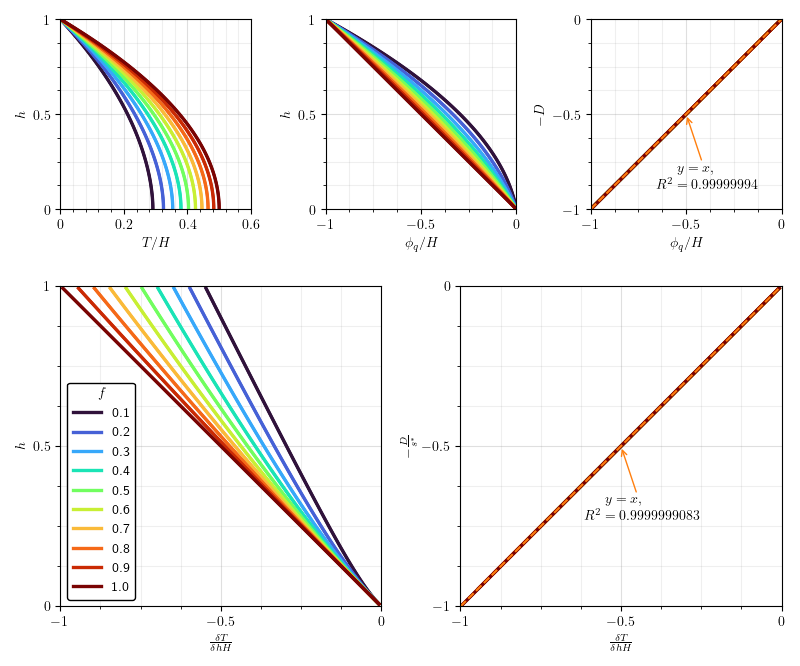

In [7]:
canvas1 = Canvas(size = (8, 8/3), shape = (1, 3))
ax1 = canvas1.make_ax((0, 0))
ax2 = canvas1.make_ax((0, 1))
ax3 = canvas1.make_ax((0, 2))
# ax4 = canvas.make_ax((1, 1))
# extract = []

allx, ally = [], []

for (H, f), values in frm.iterrows():

    if f == 1:
        f = 0.99999
    h, T = values['h'], values['geotherm']

    ax1.line(
        Channel(T / H, lims = (0, 0.5), label = 'T/H'),
        Channel(h, lims = (0, 1), label = 'h'),
        color = cmap(f, fs, style = 'turbo'),
        linewidth = H / 5
        )

    dT, hdT = analysis.derivative(T, h, n = 1)
    ax2.line(
        phichan := Channel(dT * s_star(hdT, f) / H, lims = (-1, 0), label = r"\phi_q/H"),
        Channel(hdT, lims = (0, 1), label = 'h'),
        color = cmap(f, fs, style = 'turbo'),
        linewidth = H / 5
        )
    ax3.line(
        phichan,
        dchan := Channel(-sub_area(hdT, f), label = r"-D"),
        color = cmap(f, fs, style = 'turbo'),
        linewidth = H / 5
        )
    ally.extend(dchan.data)
    allx.extend(phichan.data)

# ax2.props.edges.y.label.visible = False
# ax2.props.edges.y.ticks.major.labels = []

linscore = r2_score(ally, allx)
ax3.line(
    np.linspace(-1, 0, 10),
    np.linspace(-1, 0, 10),
    color = '#ff7f0e',
    linestyle = '--',
    )
trendlabel = r'y=x, \\ R^2 =' + str(round(linscore, 8))
ax3.annotate(
    -0.5,
    -0.5,
    label = trendlabel,
    points = (15, -45),
    arrowProps = dict(arrowstyle = "->", color = '#ff7f0e'),
    )

canvas2 = Canvas(size = (8, 4), shape = (1, 2))
ax1 = canvas2.make_ax((0, 0))
ax2 = canvas2.make_ax((0, 1))
allx, ally = [], []
for (H, f), values in frm.iterrows():
    if f == 1:
        f = 0.99999
    h, T = values['h'], values['geotherm']
    dT, hdT = analysis.derivative(T, h, n = 1)
    ax1.line(
        xchan := Channel(dT / H, lims = (-1, 0), label = r'\frac{\delta T}{\delta h H}'),
        Channel(hdT, lims = (0, 1), label = 'h'),
        color = cmap(f, fs, style = 'turbo'),
        linewidth = H / 5
        )
    ax2.line(
        xchan,
        ychan := Channel(
            -sub_area(hdT, f) / s_star(hdT, f),
            lims = (-1, 0), label = r"-\frac{D}{s^{*}}"
            ),
        color = cmap(f, fs, style = 'turbo'),
        linewidth = H / 5
        )
    ally.extend(ychan.data)
    allx.extend(xchan.data)
linscore = r2_score(ally, allx)
ax2.line(
    np.linspace(-1, 0, 10),
    np.linspace(-1, 0, 10),
    color = '#ff7f0e',
    linestyle = '--',
    )
trendlabel = r'y=x, \\ R^2 =' + str(round(linscore, 10))
ax2.annotate(
    -0.5,
    -0.5,
    label = trendlabel,
    points = (15, -45),
    arrowProps = dict(arrowstyle = "->", color = '#ff7f0e'),
    )
# ax2.props.edges.y.label.visible = False
# ax2.props.edges.y.ticks.major.labels = []

ax1.props.legend.set_handles_labels(
    (row[0] for row in ax1.collections[10::11]),
    (str(f) for f in fs),
    )
ax1.props.legend.title.text = 'f'
ax1.props.legend.title.visible = True
# ax1.props.legend.mplprops['bbox_to_anchor'] = (1.75, 1.05)
# ax1.props.legend.mplprops['ncol'] = 2
ax1.props.legend.frame.colour = 'black'
ax1.props.legend.frame.visible = True

fig = imop.vstack(canvas1, canvas2)

glue("isocondinternal", fig, display = False)
fig

# ax2.props.legend.set_handles_labels(
#     (row[0] for row in ax1.collections[10::len(Hs)]),
#     (str(f) for f in fs),
#     )
# ax2.props.legend.title.text = 'f'
# ax2.props.legend.title.visible = True
# #     ax2.props.legend.mplprops['bbox_to_anchor'] = (1.75, 1.05)
# # ax1.props.legend.mplprops['ncol'] = 2
# ax2.props.legend.frame.colour = 'black'
# ax2.props.legend.frame.visible = True

```{glue:figure} isocondinternal
:figwidth: 800px
:name: "isocondinternal"

Summary of the scaling behaviours of isoviscous conduction under internal heating $H$ for varying curvature parameter $f$ (colours as in previous charts). While samples of varying heat have been plotted, they do not appear in these charts due to the intentional factoring out of $H$, demonstrating that this parameter is a simple coefficient.
```

It was established previously that, for an internally heated system, the geotherm and geothermal gradient are represented by:

$$ \begin{align*}
{T(h)}_{c(internal)} &= \frac{H}{2} \left( 1 - h^2 \right) \\
{{T(h)}_{c(internal)}}^{'} &= H\cdot h
\end{align*} $$

This is intuitive because the source flux visible to each layer is proportional to the area below that layer, which goes linearly with height $h$ in a planar domain.

In the annulus, though, the proportion of the domain beneath a given height $h$ is instead represented by $D$, as we have shown. If we further assume that $H$ is non-dimensionalised so as to represent the total flux of the model (i.e. it equals $1$ for all geometries), then the flux through each layer height $h$ of the annulus must simply be:

$$
{\phi_q}(h) = -H \cdot D(h)
$$

We show that this holds exactly {numref}`isocondinternal`.

As before, the geothermal gradient required to transmit this flux must account for the varying layer length $s^{*}$ - a function of $h$ and the $f$ parameter. Thus:

$$
\frac{dT}{dh} \propto \frac{\phi_q}{s^{*}} = -\frac{HD}{s^{*}}
$$

The integral with respect to $h$ yields the geotherm:

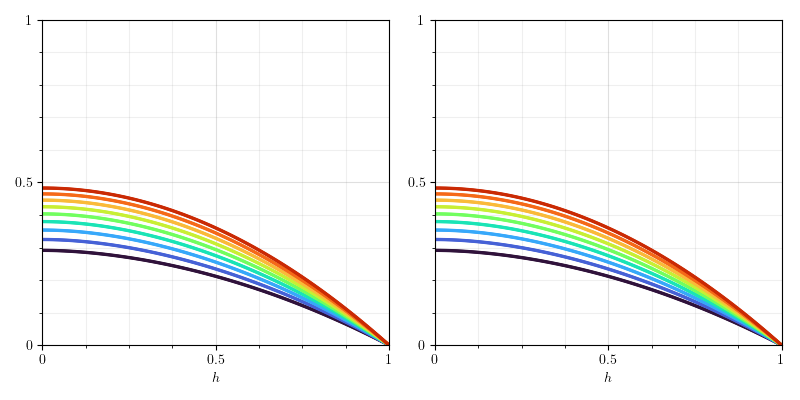

In [8]:
canvas = Canvas(size = (8, 4), shape = (1, 2))
ax1 = canvas.make_ax((0, 0))
ax2 = canvas.make_ax((0, 1))
for (H, f), values in frm.iterrows():
    if f == 1:
        continue
    h, T = values['h'], values['geotherm']
    dT, hdT = analysis.derivative(T, h, n = 1)
    sstar = s_star(hdT, f)
#     phi = dT * sstar / H
    D = -sub_area(hdT, f)
    ax1.line(
        hchan := Channel(h, lims = (0, 1), label = 'h'),
        T / H,
        color = cmap(f, fs, style = 'turbo'),
        linewidth = H / 5
        )
    ax2.line(
        hchan,
        T / H ,
        color = cmap(f, fs, style = 'turbo'),
        linewidth = H / 5
        )
# ax2.props.edges.y.label.visible = False
# ax2.props.edges.y.ticks.major.labels = []
canvas

#### Mixed heating in the annulus

##### Conductive solution

In [9]:
with open(osjoin(aliases.storagedir, 'condhfmixed.pkl'), mode = 'rb') as file:
    conddata = pickle.loads(file.read())
condhs, condfs = zip(*conddata['hfs'])
condhs = tuple(round(val, 1) for val in condhs)
frm = pd.DataFrame(dict(H = condhs, f = condfs, T = conddata['avts'], geotherm = conddata['geotherms']))
frm = frm.set_index(['H', 'f'])
Hs, fs = (np.array(sorted(set(frm.index.get_level_values(level)))) for level in ('H', 'f'))